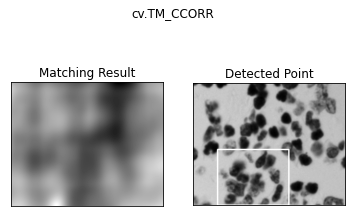

In [30]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('/content/cell2.png',0)
img2 = img.copy()
template = cv.imread('/content/cell2 template.png',0)
w, h = template.shape[::-1]
methods = [ 'cv.TM_CCORR']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]


Loading Images:

generating HistogramS:


  0%|          | 0/2 [00:02<?, ?it/s]


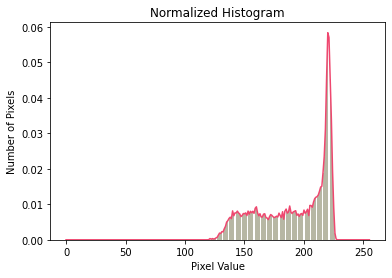

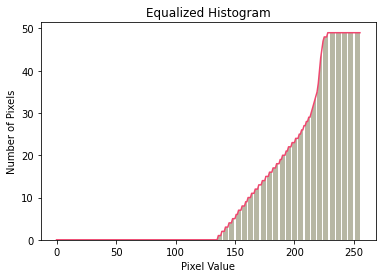

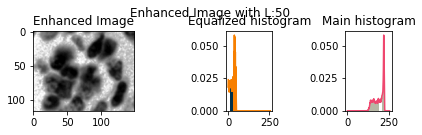

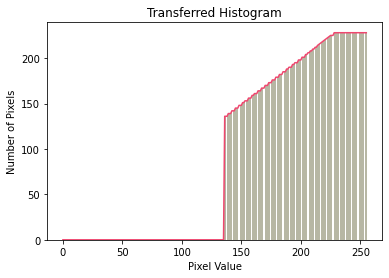

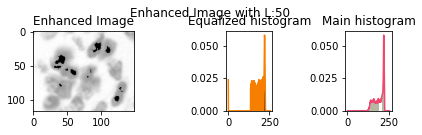

In [31]:
from scipy import stats
import random
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os.path
from tqdm import tqdm
import math
import numpy as np

def load_images():
    img_path = '/content/drive/MyDrive/images/'
    imgs = []
    for file in tqdm(os.listdir(img_path)):
        imgs.append(np.array(Image.open(img_path + file)))
    # both input images are from 0-->255
    return imgs


def print_img(img, histo_new, histo_old, index, L):
    dpi = 80
    width = img.shape[0]
    height = img.shape[1]
    if height > width:
        figsize = (img.shape[0]*4) / float(dpi), (height)/ float(dpi)
        fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [3, 1,1]}, figsize=figsize)
    else:
        figsize = (width) / float(dpi), (height*4) / float(dpi)
        fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1,1]}, figsize=figsize)

    fig.suptitle("Enhanced Image with L:" + str(L))
    axs[0].title.set_text("Enhanced Image")
    axs[0].imshow(img, vmin=np.amin(img), vmax=np.amax(img), cmap='gray')

    axs[1].title.set_text("Equalized histogram")
    axs[1].plot(histo_new, color='#f77f00')
    axs[1].bar(np.arange(len(histo_new)), histo_new, color='#003049')

    axs[2].title.set_text("Main histogram")
    axs[2].plot(histo_old, color='#ef476f')
    axs[2].bar(np.arange(len(histo_old)), histo_old, color='#b7b7a4')
    plt.tight_layout()
    plt.savefig("e" + index + str(L)+".png")


def print_histogram(_histrogram, name, title):
    plt.figure()
    plt.title(title)
    plt.plot(_histrogram, color='#ef476f')
    plt.bar(np.arange(len(_histrogram)), _histrogram, color='#b7b7a4')
    plt.ylabel('Number of Pixels')
    plt.xlabel('Pixel Value')
    plt.savefig("hist_" + name)


def generate_histogram(img, print, index):
    if len(img.shape) == 3: # img is colorful
        gr_img = np.mean(img, axis=-1)
    else:
        gr_img = img
    #now we calc grayscale histogram
    gr_hist = np.zeros([256])

    for x_pixel in range(gr_img.shape[0]):
        for y_pixel in range(gr_img.shape[1]):
            pixel_value = int(gr_img[x_pixel, y_pixel])
            gr_hist[pixel_value] += 1
    #normalize Histogram
    gr_hist /= (gr_img.shape[0] * gr_img.shape[1])
    if print:
        print_histogram(gr_hist, name="neq_"+str(index), title="Normalized Histogram")
    return gr_hist, gr_img


def equalize_histogram(img, histo, L):
    eq_histo = np.zeros_like(histo)
    en_img = np.zeros_like(img)
    for i in range(len(histo)):
        eq_histo[i] = int((L - 1) * np.sum(histo[0:i]))
    print_histogram(eq_histo, name="eq_"+str(index), title="Equalized Histogram")
    #enhance image as well:
    for x_pixel in range(img.shape[0]):
        for y_pixel in range(img.shape[1]):
            pixel_val = int(img[x_pixel, y_pixel])
            en_img[x_pixel, y_pixel] = eq_histo[pixel_val]
    #creating new histogram
    hist_img, _ = generate_histogram(en_img, print=False, index=index)
    print_img(img=en_img, histo_new=hist_img, histo_old=histo, index=str(index), L=L)
    return eq_histo


def find_value_target(val, target_arr):
    key = np.where(target_arr == val)[0]

    if len(key) == 0:
        key = find_value_target(val+1, target_arr)
        if len(key) == 0:
            key = find_value_target(val-1, target_arr)
    vvv = key[0]
    return vvv


def match_histogram(inp_img, hist_input, e_hist_input, e_hist_target, _print=True):
    en_img = np.zeros_like(inp_img)
    tran_hist = np.zeros_like(e_hist_input)
    for i in range(len(e_hist_input)):
        tran_hist[i] = find_value_target(val=e_hist_input[i], target_arr=e_hist_target)
    print_histogram(tran_hist, name="trans_hist_", title="Transferred Histogram")

    for x_pixel in range(inp_img.shape[0]):
        for y_pixel in range(inp_img.shape[1]):
            pixel_val = int(inp_img[x_pixel, y_pixel])
            en_img[x_pixel, y_pixel] = tran_hist[pixel_val]
    hist_img, _ = generate_histogram(en_img, print=False, index=3)
    print_img(img=en_img, histo_new=hist_img, histo_old=hist_input, index=str(3), L=L)


if __name__ == '__main__':
    L=50
    print("\r\nLoading Images:")
    imgs = load_images()
    print("\r\ngenerating HistogramS:")
    gr_img_arr = []
    gr_hist_arr = []
    eq_hist_arr = []
    index = 0
    for img in tqdm(imgs):
        hist_img, gr_img = generate_histogram(img, print=True, index=index)
        gr_hist_arr.append(hist_img)
        gr_img_arr.append(gr_img)
        eq_hist_arr.append(equalize_histogram(gr_img, hist_img, L))
        index += 1
        break
    match_histogram(inp_img=gr_img_arr[0], 
                    hist_input=gr_hist_arr[0], 
                    e_hist_input=eq_hist_arr[0], 
                    e_hist_target=eq_hist_arr[0])

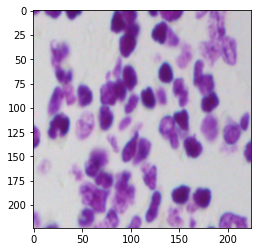

In [16]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('/content/cell2.png')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()
